# 05 — Transformer Upgrade (LSTM vs Transformer, with Sentiment & Indicators)
Workflow: เตรียมข้อมูล → LSTM benchmark → Transformer upgrade (multi-head, multi-block) → เปรียบเทียบผล + Backtest

In [1]:
%pip -q install pandas numpy matplotlib scikit-learn tensorflow==2.*


In [2]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt, tensorflow as tf
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import os

# Load dataset (with sentiment if available)
FILE = "dataset_features_labels_with_sentiment.csv"
if not os.path.exists(FILE):
    FILE = "dataset_features_labels.csv"

df = pd.read_csv(FILE, index_col=0, parse_dates=True)
print("Loaded dataset:", df.shape)
df.head(3)


Loaded dataset: (2565, 12)


,Return,Lag1,Lag2,Lag3,Lag5,Lag10,Vol_5,EMA_10,EMA_20,EMA_gap,Target,Sentiment_Daily
Date,,,,,,,,,,,,
2015-01-20,-0.000182,0.011616,-0.003702,0.000092,0.002456,-0.003823,0.007195,1521.790498,1510.543462,0.007446,0.001479,0.755929
2015-01-21,0.001479,-0.000182,0.011616,-0.003702,-0.007642,0.015681,0.005778,1524.621314,1513.097417,0.007616,0.014948,0.000000
2015-01-22,0.014948,0.001479,-0.000182,0.011616,0.000092,0.013906,0.008025,1531.115614,1517.596707,0.008908,0.024347,0.000000


In [3]:
FEATURES = [c for c in df.columns if c != "Target"]
X_all = df[FEATURES].values
y_all = df["Target"].values

n = len(df); n_train = int(n*0.7); n_val = int(n*0.85)
X_tr, y_tr = X_all[:n_train], y_all[:n_train]
X_va, y_va = X_all[n_train:n_val], y_all[n_train:n_val]
X_te, y_te = X_all[n_val:], y_all[n_val:]

# scaling
scaler = StandardScaler().fit(X_tr)
X_tr = scaler.transform(X_tr); X_va = scaler.transform(X_va); X_te = scaler.transform(X_te)

# make sequences
def make_seq(X, y, win=20):
    xs, ys = [], []
    for i in range(win, len(X)):
        xs.append(X[i-win:i])
        ys.append(y[i])
    return np.array(xs), np.array(ys)

WIN = 20
Xtr, ytr = make_seq(X_tr, y_tr, WIN)
Xva, yva = make_seq(X_va, y_va, WIN)
Xte, yte = make_seq(X_te, y_te, WIN)
idx_test = df.index[n_val+WIN:]

Xtr.shape, Xva.shape, Xte.shape, len(idx_test)


((1775, 20, 11), (365, 20, 11), (365, 20, 11), 365)

In [7]:
from tensorflow.keras import layers, models, callbacks

def build_lstm(input_shape, units=64, dropout=0.2):
    m = models.Sequential([
        layers.Input(shape=input_shape),
        layers.LSTM(units),
        layers.Dropout(dropout),
        layers.Dense(32, activation="relu"),
        layers.Dense(1)
    ])
    m.compile(optimizer="adam", loss="mse", metrics=["mae"])
    return m

lstm = build_lstm(Xtr.shape[1:])
es = callbacks.EarlyStopping(patience=10, restore_best_weights=True, monitor="val_loss")
lstm.fit(Xtr, ytr, validation_data=(Xva, yva), epochs=80, batch_size=64, callbacks=[es], verbose=0)
yhat_lstm = lstm.predict(Xte).ravel()


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


In [8]:
from tensorflow.keras import layers, models, optimizers, callbacks

def sinusoidal_position_encoding(seq_len, d_model):
    pos = np.arange(seq_len)[:, None]
    i = np.arange(d_model)[None, :]
    angle_rates = 1 / np.power(10000, (2*(i//2)) / np.float32(d_model))
    angles = pos * angle_rates
    pe = np.zeros((seq_len, d_model))
    pe[:, 0::2] = np.sin(angles[:, 0::2])
    pe[:, 1::2] = np.cos(angles[:, 1::2])
    return tf.constant(pe, dtype=tf.float32)

def build_transformer(input_shape, num_layers=2, num_heads=4, d_model=64, ff_dim=128, dropout=0.2):
    seq_len, n_feat = input_shape
    inp = layers.Input(shape=input_shape)
    x = layers.Dense(d_model)(inp)
    pe = sinusoidal_position_encoding(seq_len, d_model)
    x = x + pe
    for _ in range(num_layers):
        attn = layers.MultiHeadAttention(num_heads=num_heads, key_dim=d_model//num_heads)(x, x)
        attn = layers.Dropout(dropout)(attn)
        x = layers.LayerNormalization(epsilon=1e-6)(x + attn)
        f = layers.Dense(ff_dim, activation="relu")(x)
        f = layers.Dropout(dropout)(f)
        f = layers.Dense(d_model)(f)
        x = layers.LayerNormalization(epsilon=1e-6)(x + f)
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dense(64, activation="relu")(x)
    out = layers.Dense(1)(x)
    model = models.Model(inp, out)
    model.compile(optimizer="adam", loss="mse", metrics=["mae"])
    return model

trf = build_transformer(Xtr.shape[1:], num_layers=3, num_heads=4, d_model=64, ff_dim=128, dropout=0.2)
es2 = callbacks.EarlyStopping(patience=12, restore_best_weights=True, monitor="val_loss")
trf.fit(Xtr, ytr, validation_data=(Xva, yva), epochs=100, batch_size=64, callbacks=[es2], verbose=0)
yhat_tf = trf.predict(Xte).ravel()


12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step


LSTM: {'RMSE': 0.011741701598236053, 'MAE': 0.00880490740347719, 'R2': -0.4426010003818466, 'DA': 0.5205479452054794}
Transformer: {'RMSE': 0.00998132352182152, 'MAE': 0.007407007846075603, 'R2': -0.042462438886133214, 'DA': 0.4849315068493151}


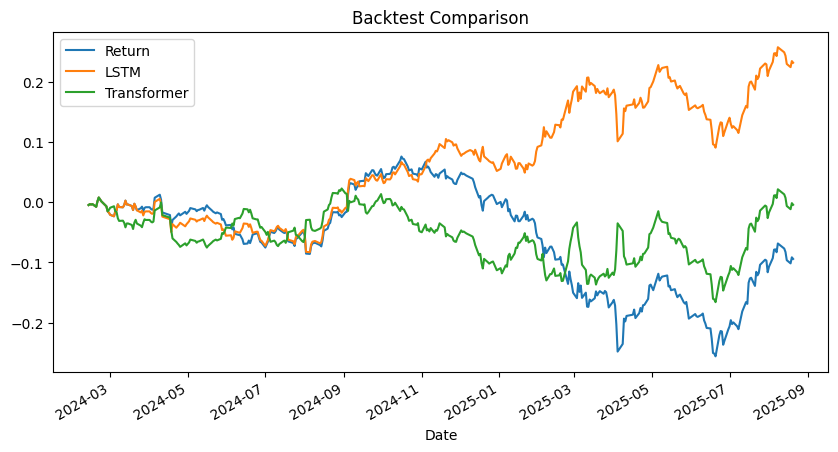

In [9]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt

def metrics(y_true, y_pred):
    return {
        "RMSE": float(np.sqrt(mean_squared_error(y_true, y_pred))),
        "MAE": float(mean_absolute_error(y_true, y_pred)),
        "R2": float(r2_score(y_true, y_pred)),
        "DA": float((np.sign(y_true)==np.sign(y_pred)).mean())
    }

m_lstm = metrics(yte, yhat_lstm)
m_trf  = metrics(yte, yhat_tf)

print("LSTM:", m_lstm)
print("Transformer:", m_trf)

bt = pd.DataFrame(index=idx_test)
bt["Return"] = yte
bt["LSTM"] = np.where(yhat_lstm>0, 1, -1) * bt["Return"]
bt["Transformer"] = np.where(yhat_tf>0, 1, -1) * bt["Return"]

bt[["Return","LSTM","Transformer"]].cumsum().plot(figsize=(10,5), title="Backtest Comparison")
plt.show()
